# SIMULACIÓN | LABORATORIO 5


## Boostrap o remuestreo

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy 
from IPython.display import display, Math
import ipywidgets as widgets
import random
import scipy.stats as stats
import statistics

### Ejercicio 1
En un estudio sobre plantaciones de coihue, se ha recopilado información sobre la altura que alcanzan dichos árboles a los 20 años de edad, en diversas zonas de la región sur austral de Chile. A partir de dichos datos, estamos interesados en calcular un intervalo de confianza para la mediana de altura que alcanza esta especie a los 20 años de edad.
Para ello utilizaremos remuestreo o bootstrap.
1. Analice el código y evalue el número de muestras de bootstrap para alcanzar convergencia de la varianza estimada de la mediana.
2. Calcule el error cuadrático medio de la mediana.
3. Escoja otro estadístico de la muestra y calcule su incerteza con la técnica de boostrap
4. Compare y comente sus resultados.

In [2]:
datos = [12.5,11.4,18.4,10.7,9.5,11.7,15.4,12.3,18.6, 14.7, 10.7,11.6, 10.1, 8.2, 11.4,21.1, 12.1, 7.5, 12.5, 14.7, 10.3, 5.4, 9.4, 13.8, 9.6, 11.3, 14.8, 12.6]
len(datos)

28

In [5]:

m = statistics.median(datos)
print (m)
b=100
mm = 0
mn =[]

# bootstrap de la profe (n not def)

n = 50
for i in range(b):
    dat = np.random.choice(list(datos),size=n,replace=True)
    mn.append(statistics.median(dat))
    
var = statistics.variance(mn)
print(var)
rango = 1.96*math.sqrt(var)
display(Math('%0.2f \pm %0.2f' % (m, rango )))

              

11.649999999999999
0.13358055555555542


<IPython.core.display.Math object>

In [9]:
# bootstrap de ricki
bstrap = np.random.choice(datos, size=30)
median_bstrap = statistics.median(bstrap)

11.899999999999999

In [10]:
# error medio cuatrático|
median_mse = (np.square(m - median_bstrap)).mean()
display(median_mse)

0.0625

In [11]:
# desviación estándar
stdev = statistics.stdev(datos)
stdev_bstrap = statistics.stdev(bstrap)
stdev_mse = (np.square(stdev - stdev_bstrap)).mean()
display(stdev_mse)


0.003384430627799473

### Ejercicio 2

Suponga que los datos previamente registrados provienen de una distribución normal de parámetros $(\mu,\sigma)$

1. Calcule los estimadores máximo verosímil de $\hat{\mu}$ y $\hat{\sigma}$
2. Utilice boostrap paramétrico para estimar la incerteza de $\hat{\mu}$ y $\hat{\sigma}$ . Estime el número de muestras para alcanzar convergencia en cada caso.
3. Compare y comente sus resultados.



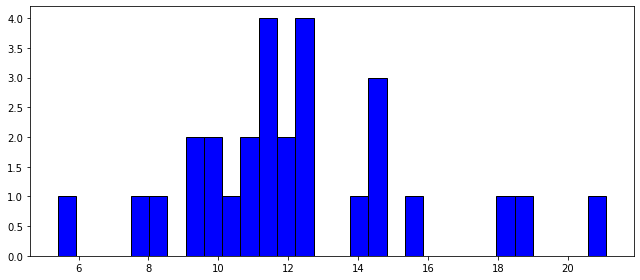

In [18]:
fig, ax = plt.subplots(1, figsize=(9,4), tight_layout= True)
ax.hist(datos, color='blue', edgecolor='black', bins=30)
plt.show()